<a href="https://colab.research.google.com/github/22anushka/Epileptic-seizure-detection-from-eeg-signals/blob/main/Epileptic_Seizure_Detection_from_EEG_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Epileptic Seizure Detection from EEG signals

```
@authors: Anushka S, Kaushik D
```

In [ ]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation , LSTM , Dropout , AveragePooling3D
import pandas as pd

import matplotlib.pyplot as plt

# Converting UBonn dataset into csv file

In [ ]:
df = pd.DataFrame({}, columns = [i for i in range (0, 4098)])

In [ ]:
# UBonn University dataset compilation
for x in ['S', 'N', 'F', 'O', 'Z']:
  if x == 'N':
    ext = '.TXT'
  else:
    ext = '.txt'
  for y in range(1,101):
    # print(str(x)+str(f"{y:03}")+'.txt')
    with open("/content/"+x.lower()+"/"+str(x)+str(f"{y:03}")+str(ext),'r') as file:
      data = file.read().split('\n')
      if x != 'E':
        data[-1] = 0
      else:
        data[-1] = 1
      df.loc[len(df)] = data
      # print(len(data))
df.rename(columns = {'4097':'y'}, inplace = True)
print(df)
print(len(df))

In [ ]:
df.to_csv("/content/data.csv")

# load data

In [ ]:
df=pd.read_csv('/content/data.csv')
# shuffle the DataFrame rows
df = df.sample(frac = 1)
df.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,4088,4089,4090,4091,4092,4093,4094,4095,4096,4097
9,9,374,-205,-871,-1325,-1291,-721,14,586,911,...,-484.0,37.0,414.0,605.0,711.0,698.0,633.0,503.0,803.0,1.0
81,81,-127,-164,-184,-209,-223,-261,-307,-411,-444,...,-90.0,-77.0,-46.0,-9.0,41.0,123.0,110.0,89.0,716.0,1.0
101,101,50,48,45,41,47,51,53,40,37,...,-63.0,-63.0,-50.0,-39.0,-25.0,-19.0,-14.0,-9.0,-37.0,3.0
3,3,84,75,21,-68,-138,-184,-197,-186,-155,...,-148.0,-171.0,-195.0,-218.0,-234.0,-238.0,-209.0,-165.0,-212.0,1.0
412,412,10,-6,-14,-14,-9,-7,1,4,0,...,47.0,33.0,24.0,20.0,23.0,22.0,15.0,6.0,-46.0,5.0


In [ ]:
X=df.values
X = X[:,1:]

In [ ]:
for i, v in enumerate(X):
  if X[i][4097] !=1:
    X[i][4097] =0
print(X)

[[ 374. -205. -871. ...  503.  803.    1.]
 [-127. -164. -184. ...   89.  716.    1.]
 [  50.   48.   45. ...   -9.  -37.    0.]
 ...
 [ -72.  -78.  -90. ...  -40.  -22.    0.]
 [ 142.  142.  138. ...   66.  142.    0.]
 [  35.   34.   34. ...   42.  -11.    0.]]


In [ ]:
plt.figure(figsize=(12,8))
plt.ylim(-1200, 1200)

for x in X:
  if x[-1] == 1:
    plt.plot(x)
# plt.legend()
plt.show()

In [ ]:
# removing category y values
X = X[:,:-1]

In [ ]:
print(X)

[[  98   88   76 ...  244  184   70]
 [-136 -121  -84 ...  -12  -13  -31]
 [   5    2   -6 ...   36   36   -5]
 ...
 [ -28  -35  -37 ...    4   -4  -13]
 [  51   38   34 ...  -90 -101    2]
 [ -63  -71  -77 ...  -31  -39  -53]]


In [ ]:
from sklearn.model_selection import train_test_split

Y=list(df['4097'])

# Preprocessing

In [ ]:
from os import fstatvfs
# denoising and bandpass filter using butterworth
from scipy.signal import butter, filtfilt
# # Cutoff frequency (in Hz)
# cutoff = 40
# Order of the filter
order = 2  # to begin with
# Sampling frequency of the ECG signal (in Hz)
fs = 173.6
# low cut freq Hz
low_cut = 1
# high cut freq Hz
high_cut = 40

# Compute the filter coefficients
nyq = 0.5 * fs # Nyquist frequency (in Hz) i.e half the sampling rate
low = low_cut / nyq
high = high_cut / nyq

b, a = butter(order, [low, high], btype='band')


In [ ]:
eeg_filtered = list()
for eeg_data in X:
  # Apply the filter
  eeg_filtered.append(filtfilt(b, a, eeg_data))

In [ ]:
# smoothing
from scipy.signal import medfilt

# define window size for median filter
window_size = 3


smoothed_data = list()
for eeg_data in eeg_filtered:
  # apply median filter to EEG signal
  smoothed_data.append(medfilt(eeg_data, kernel_size=window_size))


In [ ]:
eeg = smoothed_data

# Applying DWT

In [ ]:
import pywt

# Define wavelet family and level of decomposition
wavelet_family = 'db4'
level = 5

In [ ]:
eeg_new = list()
for eeg_data in eeg:
  # Perform DWT decomposition
  coeffs = pywt.wavedec(eeg_data, wavelet_family, level=level)

  # Get approximation coefficients (cA) and detail coefficients (cD)
  cA, cD = coeffs[0], coeffs[1:]

  # Reconstruct original signal from approximation coefficients and detail coefficients
  eeg_new.append(pywt.waverec(coeffs, wavelet_family))


In [ ]:
X = np.array(eeg_new)
print(X)

[[-2.42394723e+02 -8.63947033e+02 -1.46675976e+03 ...  1.37863492e+02
   1.37863492e+02  1.37863492e+02]
 [ 2.21074590e+02  2.21074590e+02  1.81332378e+02 ... -3.79469633e+02
   2.84217094e-14  8.52651283e-14]
 [ 8.78161375e+00  8.78161375e+00  8.78161375e+00 ...  1.22680158e+01
  -4.44089210e-15 -2.66453526e-15]
 ...
 [-1.66611031e+01 -2.54078579e+01 -3.41408007e+01 ... -2.68312623e+00
  -1.88737914e-15 -7.77156117e-16]
 [-5.34616642e+00 -5.34616642e+00 -3.81300369e-01 ... -1.16095275e+02
  -7.85557917e+01 -7.85557917e+01]
 [-1.27195329e+01 -1.27195329e+01 -1.19028589e+01 ...  2.61634501e+01
  -7.99360578e-15  3.55271368e-15]]


#Split dataset

In [ ]:
print(Y)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
Y = np.array(Y)


Y.shape
X_train, X_test, Y_train, Y_test = train_test_split(X.astype(int), Y, test_size=0.20, random_state=42)

In [ ]:
print(Y.shape)

(500,)


In [ ]:
print(Y_train.shape, X_train.shape)
# print(Y_train)

(400,) (400, 4098)


# Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
import numpy as np

def build_model(X):
    n_samples = X[0].shape[0]
    n_channels = 1  # Since the input is a 1D array, there is only one channel
    print(n_samples, n_channels)
    # Reshape the input data to a 2D array
    # X = np.reshape(X, (n_samples, n_channels))
    model =""
    model = Sequential()

    # Add the input layer
    model.add(Conv1D(filters=11, kernel_size=5, activation='relu', input_shape=(n_samples, n_channels)))

    # # Add a max pooling layer
    model.add(MaxPooling1D(pool_size=4, strides=4))

    # Add another convolutional layer
    model.add(Conv1D(filters=7, kernel_size=5, activation='relu'))

    # # Add another max pooling layer
    model.add(MaxPooling1D(pool_size=4, strides=4))

    # Flatten the output from the convolutional layers
    model.add(Flatten())

    # Add a fully connected layer
    model.add(Dense(units=50, activation='relu'))

    model.add(Dense(units=20, activation='relu'))

    # model.add(Dense(units=5, activation='relu'))

    # Add dropout to reduce overfitting
    model.add(Dropout(0.5))

    # Add the output layer with a single neuron and sigmoid activation
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


In [ ]:
model = build_model(X)

4098 1


# Model Training and Results

In [ ]:
# Train your model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=1000)


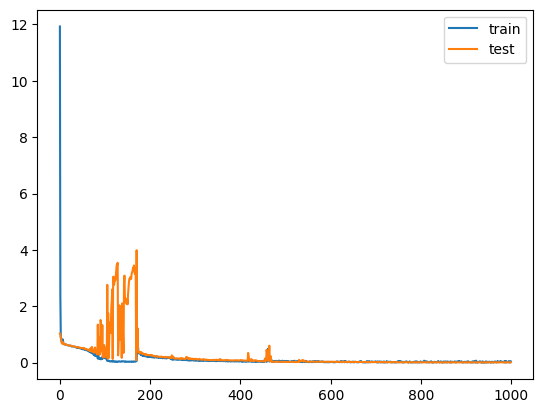

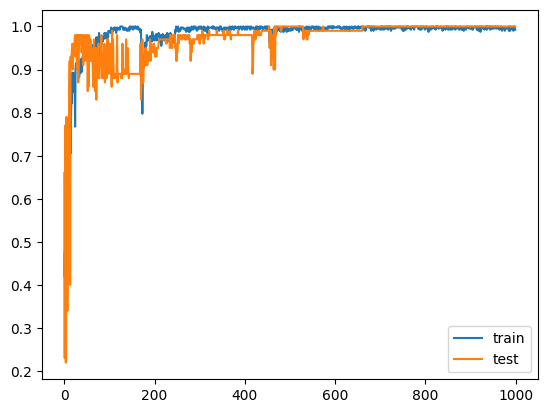

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

4/4 [==============================] - 0s 21ms/step - loss: 0.0095 - accuracy: 1.0000
Test accuracy: 1.0


In [ ]:

from sklearn.metrics import classification_report

In [ ]:
predict_x = model.predict(X_test, verbose=0)

In [ ]:
y_pred1 = (predict_x > 0.5).astype("int32")

In [ ]:
print(classification_report(Y_test,y_pred1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00        22

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [ ]:
from sklearn.metrics import roc_auc_score
# calculate AUC
auc = roc_auc_score(Y_test, predict_x)
print('AUC: %.3f' % auc)

AUC: 1.000


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, predict_x)
# calculate precision-recall AUC i.e AUPR
aupr = auc(recall, precision)
print('AUC: %.3f' % aupr)


AUC: 1.000


#Extra

In case the dataset is very imbalanced, trying to apply threshold tuning

In [ ]:
# convert to f score
fscore = list()
for i in range(0, len(precision)):
  if precision[i] != 0 and recall [i] != 0:
    fscore.append((2 * precision[i] * recall[i]) / (precision[i] + recall[i]))
  else:
    fscore.append(0)
print(fscore)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

[0.36065573770491804, 0.36974789915966383, 0.7857142857142858, 0.8, 0.8148148148148148, 0.8301886792452831, 0.846153846153846, 0.8627450980392156, 0.88, 0.8979591836734693, 0.9166666666666666, 0.9361702127659575, 0.9565217391304348, 0.9777777777777777, 1.0, 0.9767441860465117, 0.9523809523809523, 0.9268292682926829, 0.9, 0]
Best Threshold=0.997920, F-Score=1.000


In [ ]:
y_pred2 = (predict_x > thresholds[ix]).astype("int32")
# print(y_pred1)
print(classification_report(Y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        78
           1       1.00      0.95      0.98        22

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100



#Results for model

In [ ]:
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
new_model =  load_model('model.h5')

In [ ]:
test_loss, test_acc = new_model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

In [ ]:
predict_x = model.predict(X_test, verbose=0)